In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
import cv2
import pandas as pd

In [3]:
img=cv2.imread('E:/Intel/new approach/dataset/train/pixel/0_IPHONE-SE_M.JPG')

In [4]:
transforms = v2.Compose([ v2.ToImage(),
                         v2.Resize((512,512)),
                          
                         v2.ToDtype(torch.float32, scale=True)
                        ])

In [5]:
from torch.utils.data import Dataset, DataLoader

In [7]:
img_names = {}
blur=[]
sharp=[]
for img in os.listdir('E:/Intel/new approach/dataset/train/pixel'):
    blur.append(img)
for img in os.listdir('E:/Intel/new approach/dataset/train/orginal'):
    sharp.append(img)
blur.sort()
sharp.sort()
img_names['blur']=blur
img_names['sharp']=sharp

In [8]:
df=pd.DataFrame(img_names)

In [9]:
len(df)

350

In [10]:
class MyData(Dataset):
    def __init__(self,df,blur_path,sharpen_path,transform):
        self.df=df
        self.transform=transform
        self.bp=blur_path
        self.sp=sharpen_path
    def __len__(self):
        return len(self.df)
    def __getitem__(self,index):
        blur_image_path=os.path.join(self.bp,self.df['blur'][index])
        sharpen_image_path=os.path.join(self.sp,self.df['sharp'][index])
        bimg=cv2.imread(blur_image_path)
        simg=cv2.imread(sharpen_image_path)
        x = self.transform(bimg)
        y = self.transform(simg)
        return x,y
    

In [11]:
train_df=df[:245]
test_df=df[245:300]
valid_df=df[300:]

In [12]:
train_data = MyData(train_df,'E:/Intel/new approach/dataset/train/pixel','E:/Intel/new approach/dataset/train/orginal',transforms)
test_data = MyData(test_df,'E:/Intel/new approach/dataset/train/pixel','E:/Intel/new approach/dataset/train/orginal',transforms)
valid_data = MyData(valid_df,'E:/Intel/new approach/dataset/train/pixel','E:/Intel/new approach/dataset/train/orginal',transforms)

In [13]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=True)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.conv_block1 = self.conv_block(3, 64)   
        self.conv_block2 = self.conv_block(64, 128)
        self.conv_block3 = self.conv_block(128, 256)
        self.conv_block4 = self.conv_block(256, 512)
        self.conv_block5 = self.conv_block(512,1024)
        
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(1024 * 8 * 8, 4096)
        self.relu1 = nn.ReLU(inplace=True)
        self.dense2 = nn.Linear(4096, 1024 * 8 * 8)
        self.relu2 = nn.ReLU(inplace=True)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1024, 8, 8))

        self.up_conv1 = self.up_conv(1024, 512)
        self.up_conv2 = self.up_conv(512, 256)
        self.up_conv3 = self.up_conv(256, 128)
        self.up_conv4 = self.up_conv(128, 64)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=3,padding='same').to(device)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same',bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same',bias=False),
            nn.ReLU(inplace=True)
        ).to(device)

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2,bias=False)
#             nn.ReLU(inplace=True)
        ).to(device)
    def pool(self, x):
        return nn.AvgPool2d(kernel_size=2, stride=2)(x).to(device)

    def forward(self, x):
 
        out1 = self.conv_block1(x)
        pool1 = self.pool(out1)   #64, 64, 64
        
        out2 = self.conv_block2(pool1)
        pool2 = self.pool(out2)  #128, 32,32
        
        
        out3 = self.conv_block3(pool2)
        pool3 = self.pool(out3)
        
        out4 = self.conv_block4(pool3)
        pool4 = self.pool(out4)  #512, 16,16

        out5 = self.conv_block5(pool4)  #1024,8,8
        
        
        up1 = self.up_conv1(out5)  #512,16,16
        up1 = self.crop_and_concat(out4, up1) #1024,16,16
        up1 = self.conv_block(1024, 512)(up1) #512,16,16

        up2 = self.up_conv2(out4)
        up2 = self.crop_and_concat(out3, up2)
        up2 = self.conv_block(512, 256)(up2)  #256,32,32


        up3 = self.up_conv3(up2)
        up3 = self.crop_and_concat(out2, up3)
        up3 = self.conv_block(256, 128)(up3)

        up4 = self.up_conv4(up3)
        up4 = self.crop_and_concat(out1, up4)
        up4 = self.conv_block(128, 64)(up4)  # 64,128,128

        return self.final_conv(up4)  #3,128,128
    

    def crop_and_concat(self, first, second):
#         _, _, H, W = upsampled.size()
#         bypass = self.center_crop(bypass, H, W)
        return torch.cat((first, second), dim=1)

In [16]:
q = iter(train_loader)

In [17]:
x,y=next(q)


In [2]:
x.shape

NameError: name 'x' is not defined

In [19]:
y.shape

torch.Size([10, 3, 512, 512])

In [20]:
model=UNET()
l = nn.L1Loss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002) 
total_step = len(train_loader)

In [21]:
model = model.to(device)

In [22]:
num_epochs=20
for epoch in range(num_epochs):
    loss = 0
    for i, (b_img, s_img) in enumerate(train_loader):  
        optimizer.zero_grad()
        b_img, s_img = b_img.to(device, dtype=torch.float), s_img.to(device, dtype=torch.float)
        outputs = model(b_img)
        loss = l(outputs, s_img)
        
        
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/20], Loss: 1325929.1250
Epoch [2/20], Loss: 1728840.0000
Epoch [3/20], Loss: 873438.1875
Epoch [4/20], Loss: 478841.5625
Epoch [5/20], Loss: 552921.7500
Epoch [6/20], Loss: 652311.9375
Epoch [7/20], Loss: 860010.0000
Epoch [8/20], Loss: 606550.9375
Epoch [9/20], Loss: 702466.5625
Epoch [10/20], Loss: 618439.3125
Epoch [11/20], Loss: 937655.2500
Epoch [12/20], Loss: 661132.3750
Epoch [13/20], Loss: 679047.6250
Epoch [14/20], Loss: 489763.9062
Epoch [15/20], Loss: 684464.8750
Epoch [16/20], Loss: 645002.9375
Epoch [17/20], Loss: 509119.5938
Epoch [18/20], Loss: 487731.4062
Epoch [19/20], Loss: 385066.0000
Epoch [20/20], Loss: 525653.8750


In [23]:
w= iter(train_loader)

x,y=next(w)

x=x.to(device)

p=model(x)

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [25]:
def predict(t,i):
    image_tensor =t  
    image_tensor = image_tensor.squeeze(0)
    image_tensor = image_tensor.detach().cpu()
    image_tensor=image_tensor[i:i+1].view(3,512,512)
    image_np = image_tensor.numpy()
    image_np = np.transpose(image_np, (1, 2, 0))
    return image_np

In [1]:
plt.imshow(predict(x,0))
plt.axis('off')
plt.show()

NameError: name 'plt' is not defined

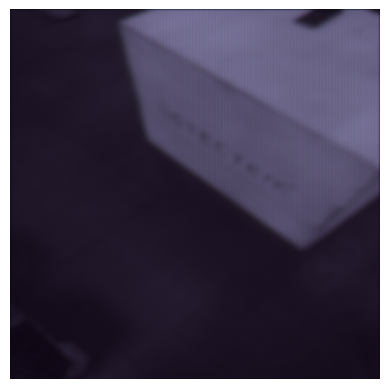

In [27]:
plt.imshow(predict(p,0))
plt.axis('off')
plt.show()


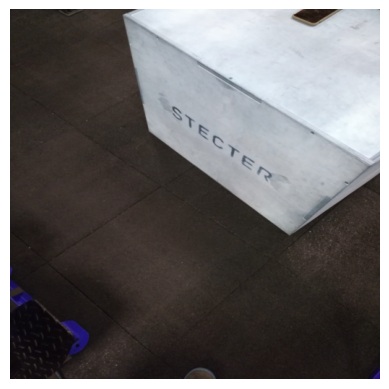

In [28]:
plt.imshow(predict(y,0))
plt.axis('off')
plt.show()